In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")

In [49]:

file_path = "train.txt"

triples = []
with open(file_path) as f:
    for line in f:
        h, r, t = line.strip().split()
        triples.append((h, r, t))

G_directed = nx.MultiDiGraph()
for h, r, t in triples:
    G_directed.add_edge(h, t, relation=r)

G = nx.Graph(G_directed)

print(f"Total people: {G.number_of_nodes()}")
print(f"Total relationships: {G.number_of_edges()}")
print(f"Unique relations: {len(set(r for _, r, _ in triples))}")

Total people: 1316
Total relationships: 7480
Unique relations: 28


In [50]:

components = list(nx.connected_components(G))
print(f"Total disconnected families: {len(components)}")

families = {}
for i, comp in enumerate(components, start=1):
    fam_id = f"F{i}"
    families[fam_id] = {
        "G": G.subgraph(comp).copy(),           
        "G_dir": G_directed.subgraph(comp).copy(),  
        "nodes": list(comp),
        "size": len(comp)
    }

sizes = [f["size"] for f in families.values()]
print(f"Family sizes: min={min(sizes)}, max={max(sizes)}, avg={np.mean(sizes):.1f}")

Total disconnected families: 50
Family sizes: min=26, max=27, avg=26.3



We'll apply community detection **within each family** to find sub-structures like:
- Nuclear families (parents + children)
- Extended family branches
- Generational clusters



### Algorithm 1: Louvain Method

We use:

1. **Louvain**: Fast modularity optimization, widely used baseline2. 

In [51]:

%pip install python-louvain -q

Note: you may need to restart the kernel to use updated packages.


In [52]:
# Apply louvain method on each family and store it
import community as community_louvain

louvain_results = {}

for fam_id, fam_data in families.items():
    G_fam = fam_data["G"]
    if G_fam.number_of_nodes() < 4:
        continue
    
    partition = community_louvain.best_partition(G_fam, resolution=1.0, random_state=42)
    
    modularity = community_louvain.modularity(partition, G_fam)
    
    num_communities = len(set(partition.values()))
    
    louvain_results[fam_id] = {
        "partition": partition,
        "modularity": modularity,
        "num_communities": num_communities,
        "family_size": G_fam.number_of_nodes()
    }

print(f"Analyzed {len(louvain_results)} families with Louvain\n")
print(f"Example results:")
for fam_id in list(louvain_results.keys())[:15]:
    r = louvain_results[fam_id]
    print(f"  {fam_id}: {r['num_communities']} communities, modularity={r['modularity']:.3f}")

Analyzed 50 families with Louvain

Example results:
  F1: 2 communities, modularity=0.073
  F2: 4 communities, modularity=0.219
  F3: 2 communities, modularity=0.169
  F4: 2 communities, modularity=0.147
  F5: 2 communities, modularity=0.174
  F6: 4 communities, modularity=0.101
  F7: 2 communities, modularity=0.264
  F8: 2 communities, modularity=0.229
  F9: 2 communities, modularity=0.146
  F10: 3 communities, modularity=0.388
  F11: 3 communities, modularity=0.202
  F12: 4 communities, modularity=0.032
  F13: 3 communities, modularity=0.159
  F14: 3 communities, modularity=0.277
  F15: 3 communities, modularity=0.152


### Algorithm 2: Spectral Clustering
- Uses graph Laplacian eigenvalues to partition the graph
- We can control the number of communities (we'll try k=2,3,4 and pick best modularity)
- Works well for dense graphs where edge-removal methods struggle

In [53]:
# Apply Spectral clustering method on each family and store it
from sklearn.cluster import SpectralClustering
from networkx.algorithms.community.quality import modularity

spectral_results = {}

for fam_id, fam_data in families.items():
    G_fam = fam_data["G"]
    
    if G_fam.number_of_nodes() < 4:
        continue
    
    # Get adjacency matrix
    nodes = list(G_fam.nodes())
    A = nx.to_numpy_array(G_fam, nodelist=nodes)
    
    best_mod = -1
    best_partition = None
    best_k = 2
    
    for k in [2,4,3,5,6,7,8,9,10]:
        if k >= len(nodes):
            continue
            
        try:
            sc = SpectralClustering(n_clusters=k, affinity='precomputed', 
                                    random_state=67, assign_labels='kmeans')
            labels = sc.fit_predict(A)
            
            # Convert to partition dict
            partition = {nodes[i]: labels[i] for i in range(len(nodes))}
            
            communities = [set(n for n, c in partition.items() if c == cid) 
                          for cid in set(labels)]
            mod = modularity(G_fam, communities)
            
            if mod > best_mod:
                best_mod = mod
                best_partition = partition
                best_k = k
        except:
            continue
    
    if best_partition is None:
        continue
    
    spectral_results[fam_id] = {
        "partition": best_partition,
        "modularity": best_mod,
        "num_communities": best_k,
        "family_size": G_fam.number_of_nodes()
    }

print(f"Analyzed {len(spectral_results)} families with Spectral Clustering")
print(f"\nSample results:")
for fam_id in list(spectral_results.keys())[:5]:
    r = spectral_results[fam_id]
    print(f"  {fam_id}: {r['num_communities']} communities, modularity={r['modularity']:.3f}")

Analyzed 50 families with Spectral Clustering

Sample results:
  F1: 4 communities, modularity=0.007
  F2: 4 communities, modularity=0.196
  F3: 3 communities, modularity=0.082
  F4: 2 communities, modularity=0.147
  F5: 6 communities, modularity=0.131




**Why is modularity low for family graphs?**
- Family graphs are **very dense** 
- Everyone is connected through multiple paths (grandparents→grandchildren, aunts→nephews)
- No natural "cuts" exist like in typical social networks

In [54]:

comparison_data = []

for fam_id in louvain_results:
    if fam_id in spectral_results:
        comparison_data.append({
            "family": fam_id,
            "size": louvain_results[fam_id]["family_size"],
            "louvain_mod": louvain_results[fam_id]["modularity"],
            "louvain_comm": louvain_results[fam_id]["num_communities"],
            "spectral_mod": spectral_results[fam_id]["modularity"],
            "spectral_comm": spectral_results[fam_id]["num_communities"]
        })

df_compare = pd.DataFrame(comparison_data)

print(f"\nLouvain:")
print(f"  Mean modularity: {df_compare['louvain_mod'].mean():.3f}")
print(f"  Mean communities: {df_compare['louvain_comm'].mean():.1f}")

print(f"\nSpectral Clustering:")
print(f"  Mean modularity: {df_compare['spectral_mod'].mean():.3f}")
print(f"  Mean communities: {df_compare['spectral_comm'].mean():.1f}")

df_compare.head(10).style.hide(axis="index")


Louvain:
  Mean modularity: 0.182
  Mean communities: 2.8

Spectral Clustering:
  Mean modularity: 0.144
  Mean communities: 3.5


family,size,louvain_mod,louvain_comm,spectral_mod,spectral_comm
F1,27,0.072627,2,0.007093,4
F2,26,0.219189,4,0.196349,4
F3,26,0.169339,2,0.082046,3
F4,26,0.147428,2,0.147428,2
F5,26,0.174192,2,0.131135,6
F6,27,0.100724,4,0.095292,2
F7,26,0.264421,2,0.256818,2
F8,27,0.229036,2,0.202037,5
F9,26,0.146371,2,0.061692,3
F10,26,0.387574,3,0.387574,3


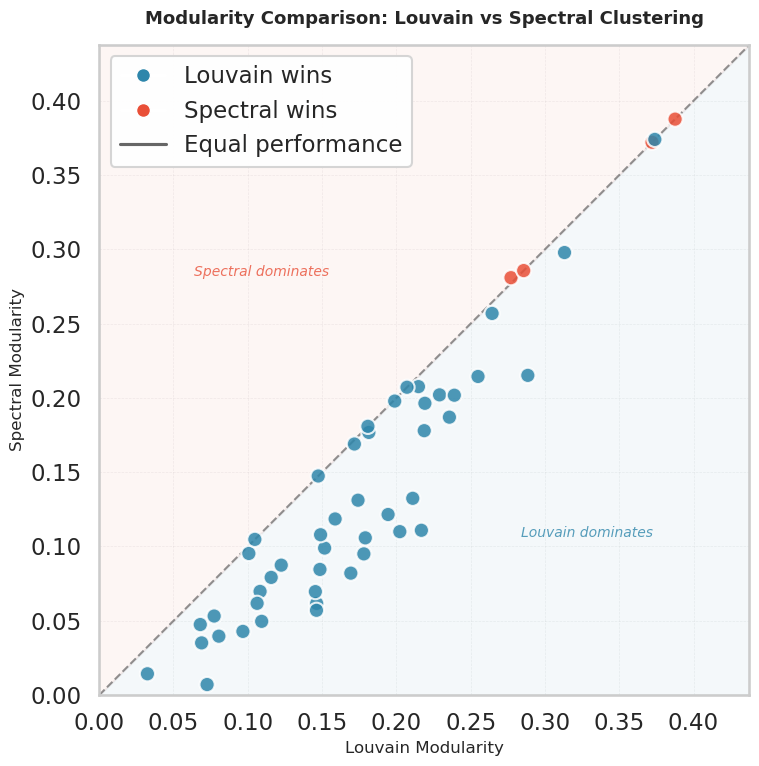

  Louvain outperforms Spectral: 44/50 families (88%)
  Spectral outperforms Louvain: 6/50 families (12%)


In [55]:
fig, ax = plt.subplots(figsize=(8, 8))

colors = ['#E94F37' if s > l else '#2E86AB' 
          for l, s in zip(df_compare['louvain_mod'], df_compare['spectral_mod'])]

ax.scatter(df_compare['louvain_mod'], df_compare['spectral_mod'], 
           s=120, c=colors, edgecolor='white', alpha=0.85, linewidths=1.5, zorder=3)

max_val = max(df_compare['louvain_mod'].max(), df_compare['spectral_mod'].max()) + 0.05
ax.plot([0, max_val], [0, max_val], color='#666666', linestyle='--', 
        linewidth=1.5, alpha=0.7, zorder=2)

ax.fill_between([0, max_val], [0, max_val], [0, 0], 
                color='#2E86AB', alpha=0.05, zorder=1)  
ax.fill_between([0, max_val], [max_val, max_val], [0, max_val], 
                color='#E94F37', alpha=0.05, zorder=1) 

ax.set_xlabel('Louvain Modularity', fontsize=12, fontweight='medium')
ax.set_ylabel('Spectral Modularity', fontsize=12, fontweight='medium')
ax.set_title('Modularity Comparison: Louvain vs Spectral Clustering', 
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_aspect('equal')

ax.annotate('Louvain dominates', xy=(0.75, 0.25), xycoords='axes fraction',
            fontsize=10, fontstyle='italic', color='#2E86AB', alpha=0.8,
            ha='center', va='center')
ax.annotate('Spectral dominates', xy=(0.25, 0.65), xycoords='axes fraction',
            fontsize=10, fontstyle='italic', color='#E94F37', alpha=0.8,
            ha='center', va='center')

ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2E86AB', 
           markersize=10, label='Louvain wins', markeredgecolor='white'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#E94F37', 
           markersize=10, label='Spectral wins', markeredgecolor='white'),
    Line2D([0], [0], color='#666666', linestyle='-', label='Equal performance')
]
ax.legend(handles=legend_elements, loc='upper left', framealpha=0.95, edgecolor='lightgray')

plt.tight_layout()
plt.show()

better_louvain = (df_compare['louvain_mod'] > df_compare['spectral_mod']).sum()
better_spectral = len(df_compare) - better_louvain
print(f"  Louvain outperforms Spectral: {better_louvain}/{len(df_compare)} families ({100*better_louvain/len(df_compare):.0f}%)")
print(f"  Spectral outperforms Louvain: {better_spectral}/{len(df_compare)} families ({100*better_spectral/len(df_compare):.0f}%)")


Across the family networks, Louvain achieves higher modularity than Spectral clustering in the large majority of cases (about 88%), indicating that direct modularity optimization better captures the dense, uneven branch structure typical of kinship graphs. Most points lie below the equality line, showing consistent Louvain advantage, while Spectral clustering only outperforms in a small subset of more evenly separable families. For families with strong community structure (higher modularity region), both methods produce similar scores, suggesting stable and well-defined subfamily groupings regardless of algorithm choice.

# Do detected communities correspond to actual family units?

Let's compare how **Louvain** and **Spectral Clustering** partition the same family.

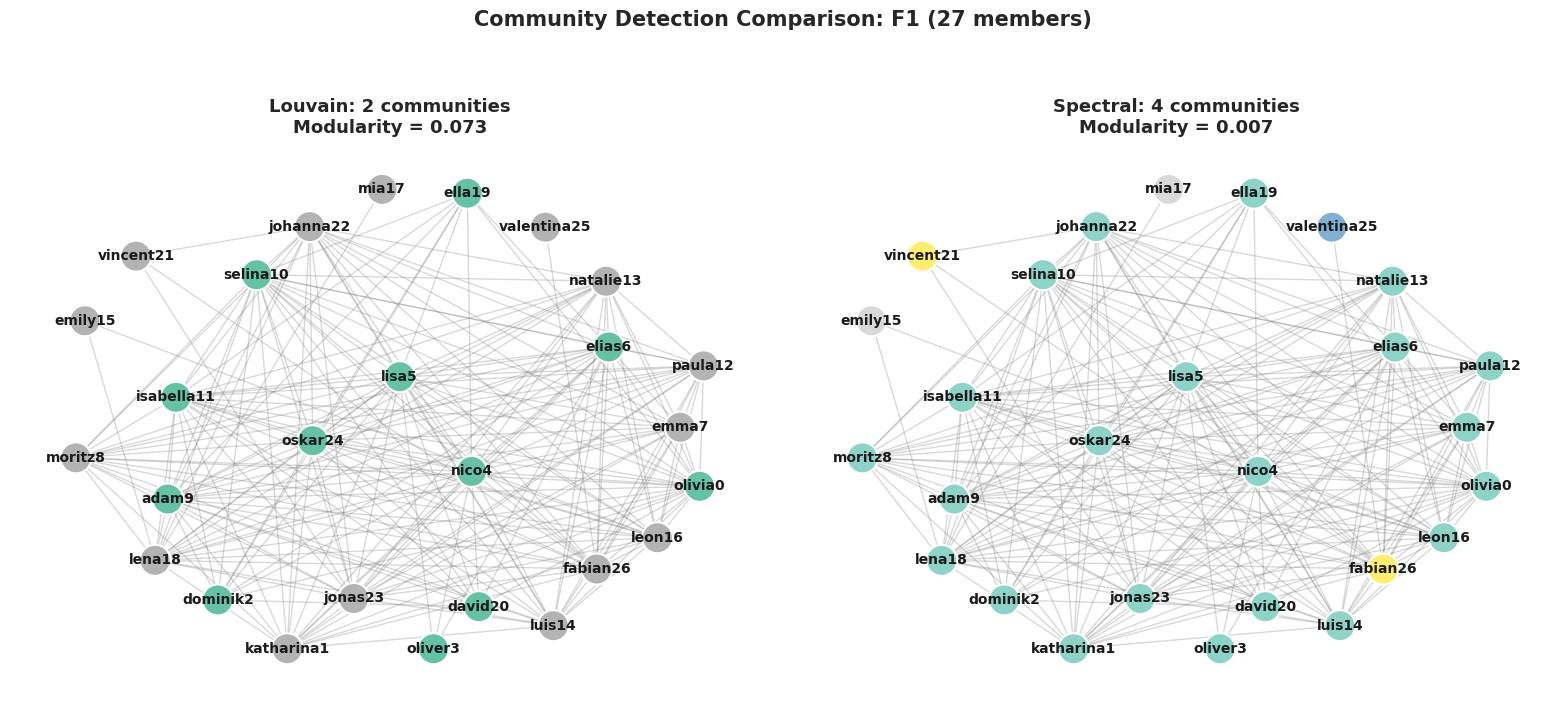

In [56]:
# Visualisation of communities by both the algos

selected_family = "F1"  #You can edit this family id

G_fam = families[selected_family]["G"]
louvain_part = louvain_results[selected_family]['partition']
spectral_part = spectral_results[selected_family]['partition']

pos = nx.spring_layout(G_fam, seed=67, k=3.5)  

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, partition, algo_name, color_map in [
    (axes[0], louvain_part, 'Louvain', plt.cm.Set2),
    (axes[1], spectral_part, 'Spectral', plt.cm.Set3)
]:
    num_comms = len(set(partition.values()))
    colors = color_map(np.linspace(0, 1, max(num_comms, 2)))
    node_colors = [colors[partition[n]] for n in G_fam.nodes()]
    
    nx.draw_networkx_edges(G_fam, pos, alpha=0.3, edge_color='gray', ax=ax)
    nx.draw_networkx_nodes(G_fam, pos, node_color=node_colors, 
                           node_size=500, edgecolors='white', linewidths=1.5, ax=ax)
    nx.draw_networkx_labels(G_fam, pos, font_size=10, font_weight='bold', ax=ax)
    
    if algo_name == 'Louvain':
        mod = louvain_results[selected_family]['modularity']
    else:
        mod = spectral_results[selected_family]['modularity']
    
    ax.set_title(f"{algo_name}: {num_comms} communities\nModularity = {mod:.3f}",
                 fontsize=13, weight='bold')
    ax.axis('off')

fig.suptitle(f"Community Detection Comparison: {selected_family} ({G_fam.number_of_nodes()} members)", 
             fontsize=15, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

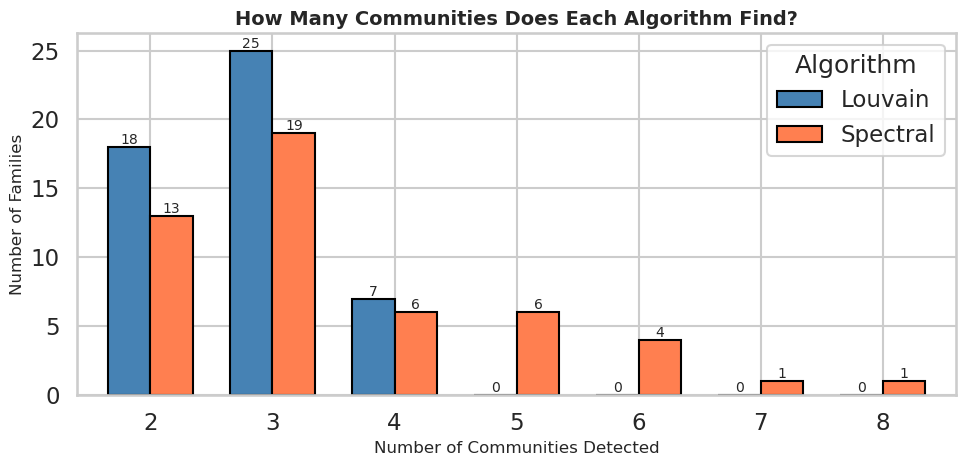

Louvain finds 2.8 communities on average (range: 2-4)
Spectral finds 3.5 communities on average (range: 2-8)


In [57]:

fig, ax = plt.subplots(figsize=(10, 5))

comm_comparison = pd.DataFrame({
    'Louvain': df_compare['louvain_comm'].value_counts().sort_index(),
    'Spectral': df_compare['spectral_comm'].value_counts().sort_index()
}).fillna(0)

comm_comparison.plot(kind='bar', ax=ax, color=['steelblue', 'coral'], edgecolor='black', width=0.7)
ax.set_xlabel('Number of Communities Detected', fontsize=12)
ax.set_ylabel('Number of Families', fontsize=12)
ax.set_title('How Many Communities Does Each Algorithm Find?', fontsize=14, weight='bold')
ax.legend(title='Algorithm')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=10)

plt.tight_layout()
plt.show()

print(f"Louvain finds {df_compare['louvain_comm'].mean():.1f} communities on average (range: {df_compare['louvain_comm'].min()}-{df_compare['louvain_comm'].max()})")
print(f"Spectral finds {df_compare['spectral_comm'].mean():.1f} communities on average (range: {df_compare['spectral_comm'].min()}-{df_compare['spectral_comm'].max()})")

In [58]:
# Define nuclear family relations 
nuclear_relations = {'motherOf', 'fatherOf', 'daughterOf', 'sonOf', 'sisterOf', 'brotherOf'}

def get_relation_between(G_dir, u, v):
    relations = []
    for _, target, data in G_dir.edges(u, data=True):
        if target == v:
            relations.append(data.get('relation'))
    for _, target, data in G_dir.edges(v, data=True):
        if target == u:
            relations.append(data.get('relation'))
    return relations

def analyze_nuclear_density(fam_id, partition, algo_name):
    G_fam = families[fam_id]["G"]
    G_dir = families[fam_id]["G_dir"]
    
    # Group nodes by community
    comm_nodes = defaultdict(list)
    for node, comm in partition.items():
        comm_nodes[comm].append(node)
    
    results = []
    for comm_id, nodes in comm_nodes.items():
        subgraph = G_fam.subgraph(nodes)
        total_edges = subgraph.number_of_edges()
        if total_edges == 0:
            continue
        
        nuclear_count = sum(1 for u, v in subgraph.edges() 
                           if any(r in nuclear_relations for r in get_relation_between(G_dir, u, v)))
        
        results.append({
            'family': fam_id,
            'algorithm': algo_name,
            'community': comm_id,
            'size': len(nodes),
            'nuclear_ratio': nuclear_count / total_edges
        })
    return results

In [59]:


nuclear_relations = {
    'motherOf', 'fatherOf',
    'daughterOf', 'sonOf',
    'sisterOf', 'brotherOf'
}

family_comparison = []

for fam_id in louvain_results:
    if fam_id not in spectral_results:
        continue

    G_dir = families[fam_id]["G_dir"]
    louvain_part = louvain_results[fam_id]["partition"]
    spectral_part = spectral_results[fam_id]["partition"]

    seen_pairs = set()
    louvain_same = 0
    spectral_same = 0
    total = 0

    for u, v, data in G_dir.edges(data=True):
        rel = data.get("relation")

        if rel not in nuclear_relations:
            continue

        key = tuple(sorted((u, v)))
        if key in seen_pairs:
            continue
        seen_pairs.add(key)

        if u not in louvain_part or v not in louvain_part:
            continue
        if u not in spectral_part or v not in spectral_part:
            continue

        total += 1

        if louvain_part[u] == louvain_part[v]:
            louvain_same += 1

        if spectral_part[u] == spectral_part[v]:
            spectral_same += 1

    if total > 0:
        family_comparison.append({
            "family": fam_id,
            "louvain_pct": 100 * louvain_same / total,
            "spectral_pct": 100 * spectral_same / total,
            "total_nuclear_pairs": total
        })

df_fam_comp = pd.DataFrame(family_comparison)

print("Nuclear Family Preservation Analysis\n")
print(f"Louvain:  {df_fam_comp['louvain_pct'].mean():.1f}% kept together "
      f"(std: {df_fam_comp['louvain_pct'].std():.1f}%)")

print(f"Spectral: {df_fam_comp['spectral_pct'].mean():.1f}% kept together "
      f"(std: {df_fam_comp['spectral_pct'].std():.1f}%)")

print(f"\nTotal nuclear relationships analyzed: "
      f"{df_fam_comp['total_nuclear_pairs'].sum()}")


Nuclear Family Preservation Analysis

Louvain:  84.1% kept together (std: 8.2%)
Spectral: 83.1% kept together (std: 9.2%)

Total nuclear relationships analyzed: 2245


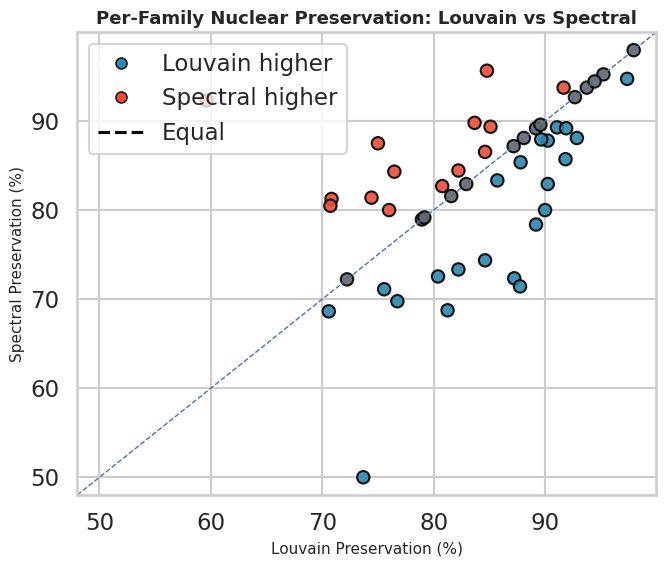

Louvain higher in 44/50 families
Spectral higher in 6/50 families
Mean preservation - Louvain:  84.1%
Mean preservation - Spectral: 83.1%


In [60]:

x = df_fam_comp["louvain_pct"]
y = df_fam_comp["spectral_pct"]

colors = np.where(x > y, "#2E86AB",
          np.where(y > x, "#E94F37", "#666666"))

plt.figure(figsize=(7, 6))
plt.scatter(x, y, c=colors, s=80, edgecolor="black", alpha=0.9)

mn = min(x.min(), y.min()) - 2
mx = max(x.max(), y.max()) + 2
plt.plot([mn, mx], [mn, mx], "--", linewidth=1)

plt.xlabel("Louvain Preservation (%)", fontsize=11)
plt.ylabel("Spectral Preservation (%)", fontsize=11)
plt.title("Per-Family Nuclear Preservation: Louvain vs Spectral", fontsize=13, weight="bold")
plt.xlim(mn, mx)
plt.ylim(mn, mx)

legend_elements = [
    Line2D([0],[0], marker='o', color='w', label='Louvain higher',
           markerfacecolor="#2E86AB", markeredgecolor="black", markersize=8),
    Line2D([0],[0], marker='o', color='w', label='Spectral higher',
           markerfacecolor="#E94F37", markeredgecolor="black", markersize=8),
    Line2D([0],[0], linestyle='--', color='black', label='Equal')
]
plt.legend(handles=legend_elements, loc="upper left")

plt.tight_layout()
plt.show()


print(f"Louvain higher in {better_louvain}/{len(df_fam_comp)} families")
print(f"Spectral higher in {better_spectral}/{len(df_fam_comp)} families")
print(f"Mean preservation - Louvain:  {df_fam_comp['louvain_pct'].mean():.1f}%")
print(f"Mean preservation - Spectral: {df_fam_comp['spectral_pct'].mean():.1f}%")



We'll use relation semantics to assign generation levels and count generations per community.

In [61]:
# Define Generation Shifts Based on Relations
gen_shift = {
    "motherOf": 1, "fatherOf": 1,
    "daughterOf": -1, "sonOf": -1,
    
    "grandmotherOf": 2, "grandfatherOf": 2,
    "granddaughterOf": -2, "grandsonOf": -2,
    
    "greatGrandmotherOf": 3, "greatGrandfatherOf": 3,
    "greatGranddaughterOf": -3, "greatGrandsonOf": -3,
    
    "sisterOf": 0, "brotherOf": 0,
    "boyCousinOf": 0, "girlCousinOf": 0,
    "boySecondCousinOf": 0, "girlSecondCousinOf": 0,
    "boyFirstCousinOnceRemovedOf": 0, "girlFirstCousinOnceRemovedOf": 0,
    
    "auntOf": 1, "uncleOf": 1,
    "nieceOf": -1, "nephewOf": -1,
    "greatAuntOf": 2, "greatUncleOf": 2,
    "secondAuntOf": 1, "secondUncleOf": 1
}

In [62]:
# Assigning generations
def assign_generations(G_dir):
    # Build generation propagation graph
    G_gen = nx.DiGraph()
    
    for u, v, data in G_dir.edges(data=True):
        rel = data.get('relation')
        if rel in gen_shift:
            G_gen.add_edge(u, v, weight=gen_shift[rel])
    
    if G_gen.number_of_nodes() == 0:
        return {}
    
    generation = {}
    
    for node in G_gen.nodes():
        if G_gen.in_degree(node) == 0:
            generation[node] = 0
    
    if not generation:
        generation[list(G_gen.nodes())[0]] = 0
    
    visited = set(generation.keys())
    queue = list(generation.keys())
    
    while queue:
        u = queue.pop(0)
        for v in G_gen.successors(u):
            if v not in visited:
                w = G_gen[u][v]['weight']
                generation[v] = generation[u] + w
                visited.add(v)
                queue.append(v)
        for v in G_gen.predecessors(u):
            if v not in visited:
                w = G_gen[v][u]['weight']
                generation[v] = generation[u] - w
                visited.add(v)
                queue.append(v)
    
    return generation

for fam_id, fam_data in families.items():
    fam_data['generations'] = assign_generations(fam_data['G_dir'])

print("Generation assignment complete!")

Generation assignment complete!


In [63]:

# # Compare for a specific family (e.g., F5 which is visualized in task1)

# debug_fam = "F5"  # Same family used in task1.ipynb generation islands visualization

# print("=" * 70)
# print(f"DEBUG: Generation Assignments for {debug_fam}")
# print("=" * 70)

# generations = families[debug_fam]['generations']

# # Group by generation level
# gen_groups = {}
# for person, gen_level in generations.items():
#     gen_groups.setdefault(gen_level, []).append(person)

# # Sort and display
# print(f"\nTotal people with assigned generations: {len(generations)}")
# print(f"Number of distinct generations: {len(gen_groups)}")
# print("\n" + "-" * 70)

# for gen_level in sorted(gen_groups.keys()):
#     people = sorted(gen_groups[gen_level])
#     print(f"\nGeneration {gen_level}: ({len(people)} people)")
#     print(f"  {people}")

# # Show some sample parent-child relationships to verify direction
# print("\n" + "=" * 70)
# print("VERIFICATION: Sample parent→child relationships")
# print("=" * 70)
# G_dir = families[debug_fam]['G_dir']

# parent_child_count = 0
# print("\nFormat: [parent] --motherOf/fatherOf--> [child] | parent_gen -> child_gen")
# print("-" * 70)

# for u, v, data in G_dir.edges(data=True):
#     rel = data.get('relation')
#     if rel in ['motherOf', 'fatherOf'] and parent_child_count < 10:
#         u_gen = generations.get(u, '?')
#         v_gen = generations.get(v, '?')
#         # Parent should be 1 generation LESS than child (older = smaller number)
#         check = "✓" if isinstance(u_gen, int) and isinstance(v_gen, int) and v_gen == u_gen + 1 else "✗"
#         print(f"  {check} {u} --{rel}--> {v}  |  gen {u_gen} -> gen {v_gen}")
#         parent_child_count += 1

# print("\n" + "-" * 70)
# print("EXPECTED: Parent gen + 1 = Child gen (child is younger = higher gen number)")
# print("If all show ✓, the generation assignment is CORRECT!")
# print("-" * 70)

In [64]:
# Count generations in community for both 
def count_generations_in_community(partition, generations):
    """Count how many distinct generations exist in each community"""
    comm_generations = defaultdict(set)
    
    for node, comm in partition.items():
        if node in generations:
            comm_generations[comm].add(generations[node])
    
    return {comm: len(gens) for comm, gens in comm_generations.items()}


gen_per_comm_data = []

for fam_id in louvain_results:
    if fam_id not in spectral_results:
        continue
        
    generations = families[fam_id].get('generations', {})
    if not generations:
        continue
    
    louvain_part = louvain_results[fam_id]['partition']
    louvain_gen_counts = count_generations_in_community(louvain_part, generations)
    for comm_id, num_gens in louvain_gen_counts.items():
        gen_per_comm_data.append({
            'family': fam_id,
            'algorithm': 'Louvain',
            'community': comm_id,
            'num_generations': num_gens
        })
    
    spectral_part = spectral_results[fam_id]['partition']
    spectral_gen_counts = count_generations_in_community(spectral_part, generations)
    for comm_id, num_gens in spectral_gen_counts.items():
        gen_per_comm_data.append({
            'family': fam_id,
            'algorithm': 'Spectral',
            'community': comm_id,
            'num_generations': num_gens
        })

df_gen_comm = pd.DataFrame(gen_per_comm_data)


print("Generations per Community: Louvain vs Spectral\n")

for algo in ["Louvain", "Spectral"]:
    df_algo = df_gen_comm[df_gen_comm['algorithm'] == algo]

    if df_algo.empty:
        print(f"{algo}: no data")
        continue

    print(f"{algo}:")
    print(f"  Communities analyzed: {len(df_algo)}")
    print(f"  Avg generations per community: {df_algo['num_generations'].mean():.2f}")
    print(f"  Most common generation count: {df_algo['num_generations'].mode().values[0]}")
    print(f"  Max generations in a community: {df_algo['num_generations'].max()}")
    print()

    

Generations per Community: Louvain vs Spectral

Louvain:
  Communities analyzed: 139
  Avg generations per community: 3.84
  Most common generation count: 4
  Max generations in a community: 6

Spectral:
  Communities analyzed: 176
  Avg generations per community: 3.07
  Most common generation count: 4
  Max generations in a community: 6



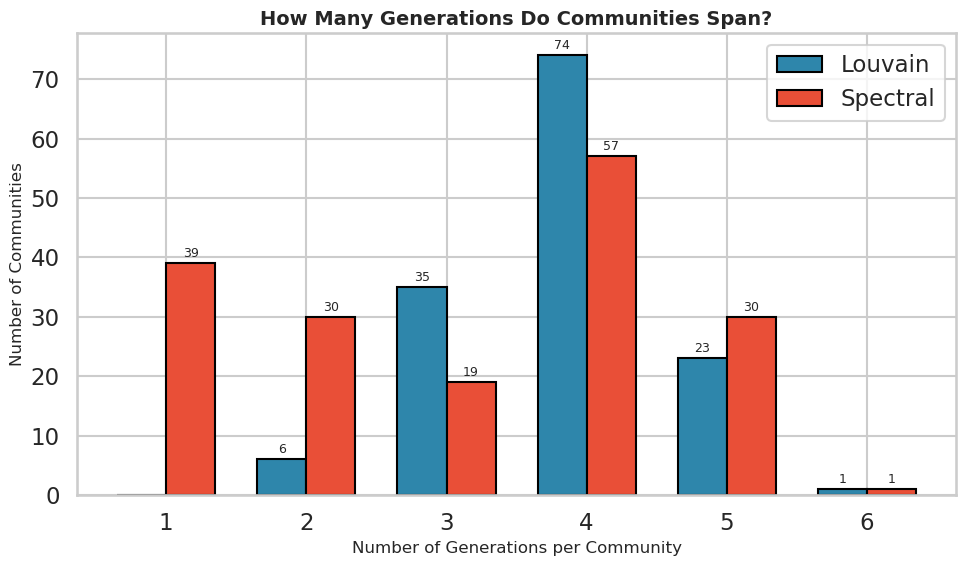


Generational Structure Summary

Louvain:  3.84 generations per community (median: 4)
Spectral: 3.07 generations per community (median: 4)


In [65]:
# PLOT How many generations do communities typically span?
fig, ax = plt.subplots(figsize=(10, 6))

louvain_counts = df_gen_comm[df_gen_comm['algorithm'] == 'Louvain']['num_generations'].value_counts().sort_index()
spectral_counts = df_gen_comm[df_gen_comm['algorithm'] == 'Spectral']['num_generations'].value_counts().sort_index()

all_gens = sorted(set(louvain_counts.index) | set(spectral_counts.index))
x = np.arange(len(all_gens))
width = 0.35

bars1 = ax.bar(x - width/2, [louvain_counts.get(g, 0) for g in all_gens], width, 
               label='Louvain', color='#2E86AB', edgecolor='black')
bars2 = ax.bar(x + width/2, [spectral_counts.get(g, 0) for g in all_gens], width,
               label='Spectral', color='#E94F37', edgecolor='black')

ax.set_xlabel('Number of Generations per Community', fontsize=12)
ax.set_ylabel('Number of Communities', fontsize=12)
ax.set_title('How Many Generations Do Communities Span?', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(all_gens)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nGenerational Structure Summary")
print(f"\nLouvain:  {df_gen_comm[df_gen_comm['algorithm']=='Louvain']['num_generations'].mean():.2f} generations per community (median: {df_gen_comm[df_gen_comm['algorithm']=='Louvain']['num_generations'].median():.0f})")
print(f"Spectral: {df_gen_comm[df_gen_comm['algorithm']=='Spectral']['num_generations'].mean():.2f} generations per community (median: {df_gen_comm[df_gen_comm['algorithm']=='Spectral']['num_generations'].median():.0f})")


### Bridge Individuals

Bridge individuals are people who connect different communities within a family. They can be identified by:
1. **Betweenness centrality** - High betweenness means many paths pass through them
2. **Inter-community edges** - Nodes with neighbors in multiple communities

In [66]:
# Identify Bridge Individuals - Using BOTH Louvain and Spectral

def find_bridge_individuals(G_fam, partition):
    bridges = []
    
    for node in G_fam.nodes():
        node_comm = partition[node]
        neighbor_comms = {partition[nbr] for nbr in G_fam.neighbors(node)}
        other_comms = neighbor_comms - {node_comm}
        
        if len(other_comms) > 0:
            bridges.append({
                'node': node,
                'own_community': node_comm,
                'other_communities': len(other_comms),
                'total_communities': len(neighbor_comms),
                'num_neighbors': G_fam.degree(node)
            })
    
    return pd.DataFrame(bridges)

bridge_stats_louvain = []
bridge_stats_spectral = []
all_bridges_louvain = []
all_bridges_spectral = []

for fam_id in louvain_results:
    if fam_id not in spectral_results:
        continue
    
    G_fam = families[fam_id]["G"]
    num_nodes = G_fam.number_of_nodes()
    
    louvain_part = louvain_results[fam_id]['partition']
    df_bridges_l = find_bridge_individuals(G_fam, louvain_part)
    bridge_stats_louvain.append({
        'family': fam_id,
        'total_nodes': num_nodes,
        'num_bridges': len(df_bridges_l),
        'bridge_pct': 100 * len(df_bridges_l) / num_nodes,
        'num_communities': louvain_results[fam_id]['num_communities']
    })
    if not df_bridges_l.empty:
        df_bridges_l['family'] = fam_id
        all_bridges_louvain.append(df_bridges_l)
    
    spectral_part = spectral_results[fam_id]['partition']
    df_bridges_s = find_bridge_individuals(G_fam, spectral_part)
    bridge_stats_spectral.append({
        'family': fam_id,
        'total_nodes': num_nodes,
        'num_bridges': len(df_bridges_s),
        'bridge_pct': 100 * len(df_bridges_s) / num_nodes,
        'num_communities': spectral_results[fam_id]['num_communities']
    })
    if not df_bridges_s.empty:
        df_bridges_s['family'] = fam_id
        all_bridges_spectral.append(df_bridges_s)

df_bridge_stats_louvain = pd.DataFrame(bridge_stats_louvain)
df_bridge_stats_spectral = pd.DataFrame(bridge_stats_spectral)
df_all_bridges_louvain = pd.concat(all_bridges_louvain, ignore_index=True) if all_bridges_louvain else pd.DataFrame()
df_all_bridges_spectral = pd.concat(all_bridges_spectral, ignore_index=True) if all_bridges_spectral else pd.DataFrame()

df_bridge_compare = pd.DataFrame({
    'family': df_bridge_stats_louvain['family'],
    'louvain_bridge_pct': df_bridge_stats_louvain['bridge_pct'],
    'spectral_bridge_pct': df_bridge_stats_spectral['bridge_pct'],
    'louvain_communities': df_bridge_stats_louvain['num_communities'],
    'spectral_communities': df_bridge_stats_spectral['num_communities']
})

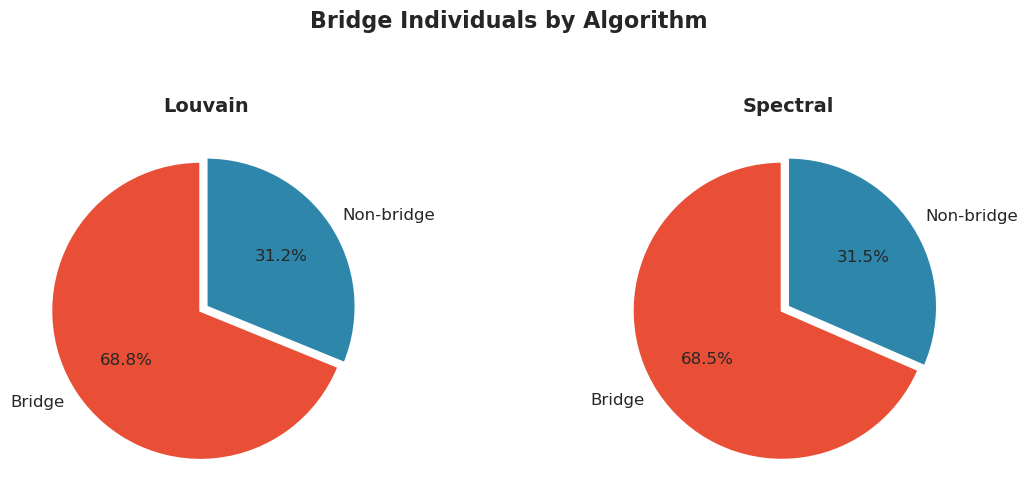

  - Both algorithms identify ~68-69% of nodes as bridges
  - Louvain: 906 bridges | Spectral: 902 bridges
  - High bridge % is expected in dense family graphs
    where most people connect to multiple communities


In [67]:
# Bridge Individuals: Pie Chart Comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors_bridge = ['#E94F37', '#2E86AB']  

louvain_mean = df_bridge_compare['louvain_bridge_pct'].mean()
axes[0].pie([louvain_mean, 100-louvain_mean], labels=['Bridge', 'Non-bridge'], 
            colors=colors_bridge, autopct='%1.1f%%', startangle=90,
            explode=(0.05, 0), textprops={'fontsize': 12})
axes[0].set_title('Louvain', fontsize=14, fontweight='bold')

spectral_mean = df_bridge_compare['spectral_bridge_pct'].mean()
axes[1].pie([spectral_mean, 100-spectral_mean], labels=['Bridge', 'Non-bridge'], 
            colors=colors_bridge, autopct='%1.1f%%', startangle=90,
            explode=(0.05, 0), textprops={'fontsize': 12})
axes[1].set_title('Spectral', fontsize=14, fontweight='bold')

fig.suptitle('Bridge Individuals by Algorithm', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"  - Both algorithms identify ~68-69% of nodes as bridges")
print(f"  - Louvain: {len(df_all_bridges_louvain)} bridges | Spectral: {len(df_all_bridges_spectral)} bridges")
print(f"  - High bridge % is expected in dense family graphs")
print(f"    where most people connect to multiple communities")

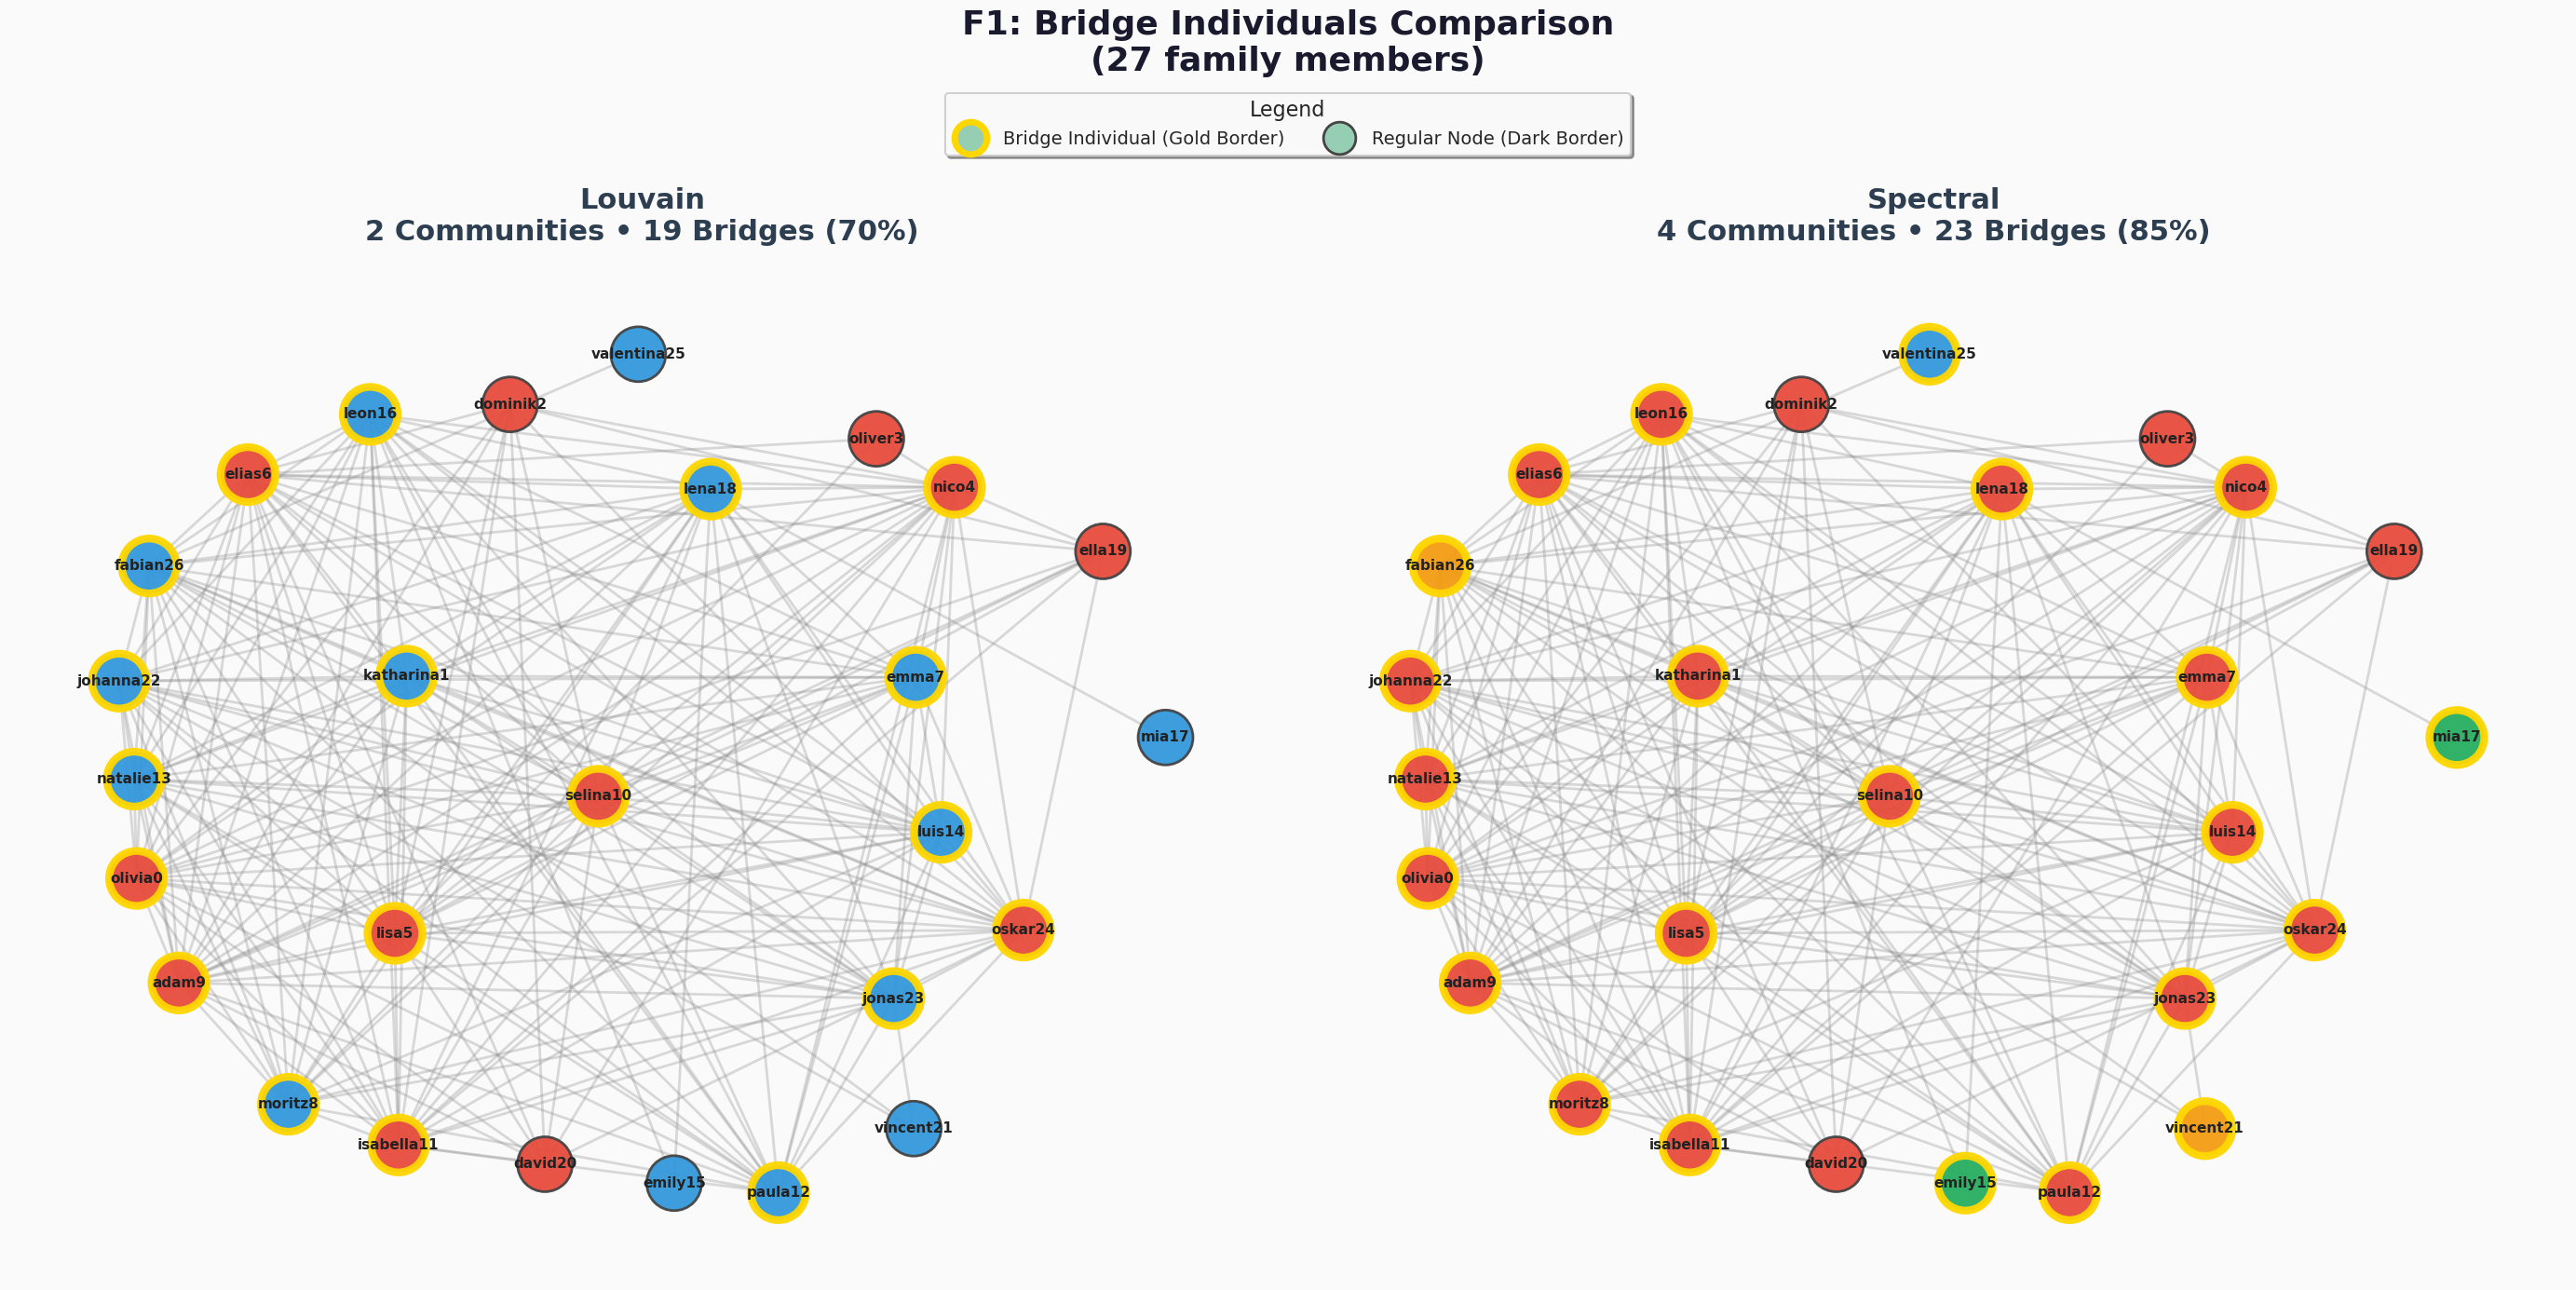

   Visualisation
   - Different COLORS = Different Communities detected
   - GOLD BORDER = Bridge Individual (connects multiple communities)
   - Dark Border = Regular node (stays within its community)

   F1 BRIDGE ANALYSIS
   - Louvain:  19 bridges (70%)
   - Spectral: 23 bridges (85%)
   - Overlap:  19 nodes identified by both


In [68]:
# Visualisation of family Network with Bridges Highlighted (Louvain vs Spectral)
sample_fam = "F1"  # you can edit this to visualisation of diff familes

G_fam = families[sample_fam]["G"]
louvain_part = louvain_results[sample_fam]['partition']
spectral_part = spectral_results[sample_fam]['partition']

bridges_louvain = set(df_all_bridges_louvain[df_all_bridges_louvain['family'] == sample_fam]['node'])
bridges_spectral = set(df_all_bridges_spectral[df_all_bridges_spectral['family'] == sample_fam]['node'])

pos = nx.spring_layout(G_fam, seed=42, k=3.5)  

fig, axes = plt.subplots(1, 2, figsize=(28, 16)) 
fig.patch.set_facecolor('#fafafa')

community_palette = ['#E74C3C', '#3498DB', '#27AE60', '#F39C12', '#9B59B6', '#E91E63', '#00BCD4']

for ax, partition, bridges, algo_name in [
    (axes[0], louvain_part, bridges_louvain, 'Louvain'),
    (axes[1], spectral_part, bridges_spectral, 'Spectral')
]:
    ax.set_facecolor('#fafafa')
    num_comms = len(set(partition.values()))
    
    node_colors = [community_palette[partition[n] % len(community_palette)] for n in G_fam.nodes()]
    
    edge_colors = ['#FFD700' if n in bridges else '#444444' for n in G_fam.nodes()]
    linewidths = [6 if n in bridges else 2 for n in G_fam.nodes()]
    
    nx.draw_networkx_edges(G_fam, pos, alpha=0.3, edge_color='#888888', 
                           width=2, ax=ax)
    
    nx.draw_networkx_nodes(G_fam, pos, node_color=node_colors, node_size=1800,
                           edgecolors=edge_colors, linewidths=linewidths, ax=ax, alpha=0.95)
    
    nx.draw_networkx_labels(G_fam, pos, font_size=11, font_weight='bold', 
                            font_color='#222222', ax=ax)
    
    bridge_pct = 100 * len(bridges) / G_fam.number_of_nodes()
    ax.set_title(f'{algo_name}\n{num_comms} Communities • {len(bridges)} Bridges ({bridge_pct:.0f}%)', 
                 fontsize=22, fontweight='bold', color='#2c3e50', pad=20)
    ax.axis('off')




bridge_legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#96CEB4', 
           markersize=25, markeredgecolor='#FFD700', markeredgewidth=5, label='Bridge Individual (Gold Border)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#96CEB4', 
           markersize=25, markeredgecolor='#444444', markeredgewidth=2, label='Regular Node (Dark Border)')
]


all_legend = bridge_legend
fig.legend(handles=all_legend,   loc='upper center', ncol=3, fontsize=14, 
           frameon=True, fancybox=True, shadow=True, framealpha=0.95,
           bbox_to_anchor=(0.5, 0.92), title='Legend', title_fontsize=16)

fig.suptitle(f'{sample_fam}: Bridge Individuals Comparison\n({G_fam.number_of_nodes()} family members)', 
             fontsize=26, fontweight='bold', color='#1a1a2e', y=0.97)

plt.tight_layout(rect=[0, 0.1, 1, 0.93])
plt.show()


print("   Visualisation")
print("   - Different COLORS = Different Communities detected")
print("   - GOLD BORDER = Bridge Individual (connects multiple communities)")
print("   - Dark Border = Regular node (stays within its community)")
print()
print(f"   {sample_fam} BRIDGE ANALYSIS")
print(f"   - Louvain:  {len(bridges_louvain)} bridges ({100*len(bridges_louvain)/G_fam.number_of_nodes():.0f}%)")
print(f"   - Spectral: {len(bridges_spectral)} bridges ({100*len(bridges_spectral)/G_fam.number_of_nodes():.0f}%)")
print(f"   - Overlap:  {len(bridges_louvain & bridges_spectral)} nodes identified by both")


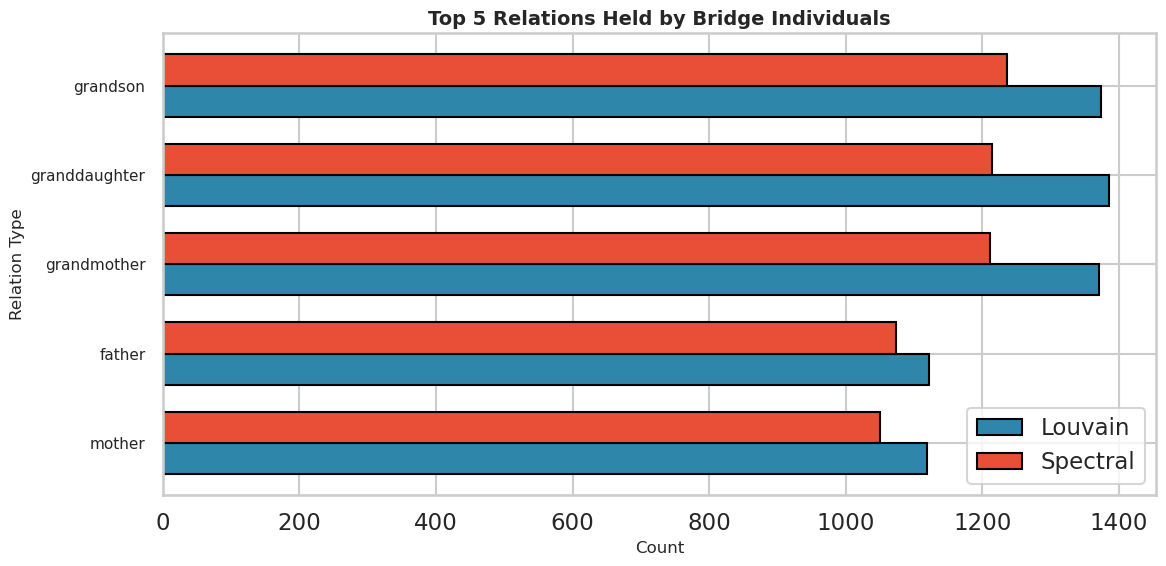



INSIGHTS: Bridge Relation Types
  - Top 5 relations are mostly extended family roles
  - Nuclear in top 5: 2 | Extended: 3
  - Bridges connect family branches via grandparent/aunt/uncle ties


In [69]:
# showing the top 5 realtions held by bridged individuals

def get_bridge_relations(df_bridges, families):
    relations = []
    for _, row in df_bridges.iterrows():
        node = row['node']
        fam_id = row['family']
        G_dir = families[fam_id]['G_dir']
        for _, _, data in G_dir.edges(node, data=True):
            relations.append(data.get('relation'))
        for _, _, data in G_dir.in_edges(node, data=True):
            relations.append(data.get('relation'))
    return Counter(relations)

rel_counts_louvain = get_bridge_relations(df_all_bridges_louvain, families)
rel_counts_spectral = get_bridge_relations(df_all_bridges_spectral, families)

all_rels = set(list(rel_counts_louvain.keys())[:10] + list(rel_counts_spectral.keys())[:10])
top_rels = sorted(all_rels, key=lambda x: rel_counts_louvain.get(x, 0) + rel_counts_spectral.get(x, 0), reverse=True)[:5]

fig, ax = plt.subplots(figsize=(12, 6))

y = np.arange(len(top_rels))
height = 0.35

louvain_vals = [rel_counts_louvain.get(r, 0) for r in top_rels]
spectral_vals = [rel_counts_spectral.get(r, 0) for r in top_rels]

bars1 = ax.barh(y + height/2, louvain_vals, height, label='Louvain', color='#2E86AB', edgecolor='black')
bars2 = ax.barh(y - height/2, spectral_vals, height, label='Spectral', color='#E94F37', edgecolor='black')

ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Relation Type', fontsize=12)
ax.set_title('Top 5 Relations Held by Bridge Individuals', fontsize=14, fontweight='bold')
ax.set_yticks(y)
ax.set_yticklabels([r.replace('Of', '') for r in top_rels], fontsize=11)
ax.legend(loc='lower right')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

nuclear_rels = {'motherOf', 'fatherOf', 'daughterOf', 'sonOf', 'sisterOf', 'brotherOf'}
nuclear_in_top = [r for r in top_rels if r in nuclear_rels]
print("\n" )
print("INSIGHTS: Bridge Relation Types")
print(f"  - Top 5 relations are mostly extended family roles")
print(f"  - Nuclear in top 5: {len(nuclear_in_top)} | Extended: {5 - len(nuclear_in_top)}")
print(f"  - Bridges connect family branches via grandparent/aunt/uncle ties")


## Relatedness Metric

Beyond counting hops, we propose a **weighted relatedness score** :


**Formula:** `relatedness = 0.35 * path_score +0.50 * relation_score +0.15 * community_bonus`

In [ ]:
# Cell 18: Define Relation Weights for Relatedness
# Higher weight =stronger relationship
relation_weights = {
    "motherOf": 1.0, "fatherOf": 1.0,
    "daughterOf": 1.0, "sonOf": 1.0,
    "sisterOf": 1.0, "brotherOf": 1.0,
    
    "grandmotherOf": 0.8, "grandfatherOf": 0.8,
    "granddaughterOf": 0.8, "grandsonOf": 0.8,
    
    "greatGrandmotherOf": 0.5, "greatGrandfatherOf": 0.5,
    "greatGranddaughterOf": 0.5, "greatGrandsonOf": 0.5,
    
    "auntOf": 0.6, "uncleOf": 0.6,
    "nieceOf": 0.6, "nephewOf": 0.6,
    "greatAuntOf": 0.4, "greatUncleOf": 0.4,
    "secondAuntOf": 0.3, "secondUncleOf": 0.3,
    
    "boyCousinOf": 0.6, "girlCousinOf": 0.6,
    "boySecondCousinOf": 0.3, "girlSecondCousinOf": 0.3,
    "boyFirstCousinOnceRemovedOf": 0.35, "girlFirstCousinOnceRemovedOf": 0.35
}

DEFAULT_WEIGHT = 0.1

In [ ]:
#Build Weighted Graph for Relatedness Calculation
def build_weighted_family_graph(G_dir):
    G_weighted = nx.Graph()
    
    for u, v, data in G_dir.edges(data=True):
        rel = data.get('relation')
        weight = relation_weights.get(rel, DEFAULT_WEIGHT)
        
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] = max(G_weighted[u][v]['weight'], weight)
        else:
            G_weighted.add_edge(u, v, weight=weight, relation=rel)
    
    return G_weighted

# Build weighted graphs for all families
for fam_id, fam_data in families.items():
    fam_data['G_weighted'] = build_weighted_family_graph(fam_data['G_dir'])

print("Weighted graphs built for all families!")

Weighted graphs built for all families!


In [ ]:
# Define the relatedness function

def calculate_relatedness(person1, person2, fam_id, partition=None):
    

    G_unweighted = families[fam_id]["G"]
    G_weighted   = families[fam_id]["G_weighted"]

    if not nx.has_path(G_unweighted, person1, person2):
        return 0.0

    if person1 == person2:
        return 1.0

    try:
        path = nx.shortest_path(G_weighted, person1, person2, weight="cost")
    except:
        return 0.0

    path_length = len(path) - 1
    path_score = 1.0 / (1 + path_length)   

    edge_weights = []
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        if G_weighted.has_edge(u, v):
            edge_weights.append(G_weighted[u][v]["weight"])
        else:
            edge_weights.append(DEFAULT_WEIGHT)

    if edge_weights:
        relation_score = float(np.exp(np.mean(np.log(edge_weights))))
    else:
        relation_score = DEFAULT_WEIGHT

    community_bonus = 0.0
    if partition and person1 in partition and person2 in partition:
        if partition[person1] == partition[person2]:
            community_bonus = 1 

    relatedness = (
        0.35 * path_score +
        0.50 * relation_score +
        0.15 * community_bonus
    )

    return min(1.0, relatedness)


print("Relatedness function loaded")


Corrected relatedness function loaded


In [98]:
# Pick a sample family and compare relatedness scores
sample_fam = "F1"  
G_fam = families[sample_fam]["G"]
partition = louvain_results.get(sample_fam, {}).get('partition', {})

nodes = list(G_fam.nodes())[:20]

print(f"Relatedness Scores in {sample_fam} \n")
print(f"{'Person 1':<15} {'Person 2':<15} {'Hops':<6} {'Relatedness':<12} {'Same Comm?'}")
print("-" * 60)

for i in range(min(5, len(nodes))):
    for j in range(i+1, min(8, len(nodes))):
        p1, p2 = nodes[i], nodes[j]
        
        if nx.has_path(G_fam, p1, p2):
            hops = nx.shortest_path_length(G_fam, p1, p2)
            score = calculate_relatedness(p1, p2, sample_fam, partition)
            same_comm = "Yes" if partition.get(p1) == partition.get(p2) else "No"
            
            print(f"{p1:<15} {p2:<15} {hops:<6} {score:<12.3f} {same_comm}")

Relatedness Scores in F1 

Person 1        Person 2        Hops   Relatedness  Same Comm?
------------------------------------------------------------
valentina25     emma7           2      0.485        Yes
valentina25     moritz8         2      0.485        Yes
valentina25     johanna22       2      0.519        Yes
valentina25     oliver3         3      0.422        No
valentina25     elias6          2      0.391        No
valentina25     oskar24         2      0.412        No
valentina25     adam9           2      0.412        No
emma7           moritz8         2      0.632        Yes
emma7           johanna22       1      0.590        Yes
emma7           oliver3         2      0.470        No
emma7           elias6          1      0.425        No
emma7           oskar24         1      0.575        No
emma7           adam9           1      0.575        No
moritz8         johanna22       1      0.590        Yes
moritz8         oliver3         2      0.470        No
moritz8         el

In [78]:
# Build comparison dataframe of hop distance vs relatedness for one family
def compare_metrics_family(fam_id, num_pairs=50):
    """Compare our relatedness metric vs simple hop count"""
    G_fam = families[fam_id]["G"]
    G_dir = families[fam_id]["G_dir"]
    partition = louvain_results.get(fam_id, {}).get('partition', {})
    nodes = list(G_fam.nodes())
    
    comparisons = []
    
    import random
    random.seed(42)
    pairs = [(random.choice(nodes), random.choice(nodes)) for _ in range(num_pairs * 3)]
    
    for p1, p2 in pairs:
        if p1 != p2 and nx.has_path(G_fam, p1, p2):
            hops = nx.shortest_path_length(G_fam, p1, p2)
            relatedness = calculate_relatedness(p1, p2, fam_id, partition)
            comparisons.append({'hops': hops, 'relatedness': relatedness})
        
        if len(comparisons) >= num_pairs:
            break
    
    return pd.DataFrame(comparisons)


In [83]:
# Find for all families
all_comparisons = []

for fam_id in list(louvain_results.keys())[:15]:
    df_comp = compare_metrics_family(fam_id)
    all_comparisons.append(df_comp)

df_all_comp = pd.concat(all_comparisons, ignore_index=True)



In [84]:
# Compute mean, std, and count of relatedness for each hop distance
hop_stats = (
    df_all_comp
    .groupby('hops')['relatedness']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

hop_stats


,hops,mean,std,count
0,1,0.550584,0.114846,317
1,2,0.448803,0.069228,321
2,3,0.418714,0.047509,102
3,4,0.380701,0.057929,10


In [ ]:
# Prepare arrays for plotting 
hops = hop_stats['hops'].values
means = hop_stats['mean'].values
stds = hop_stats['std'].values


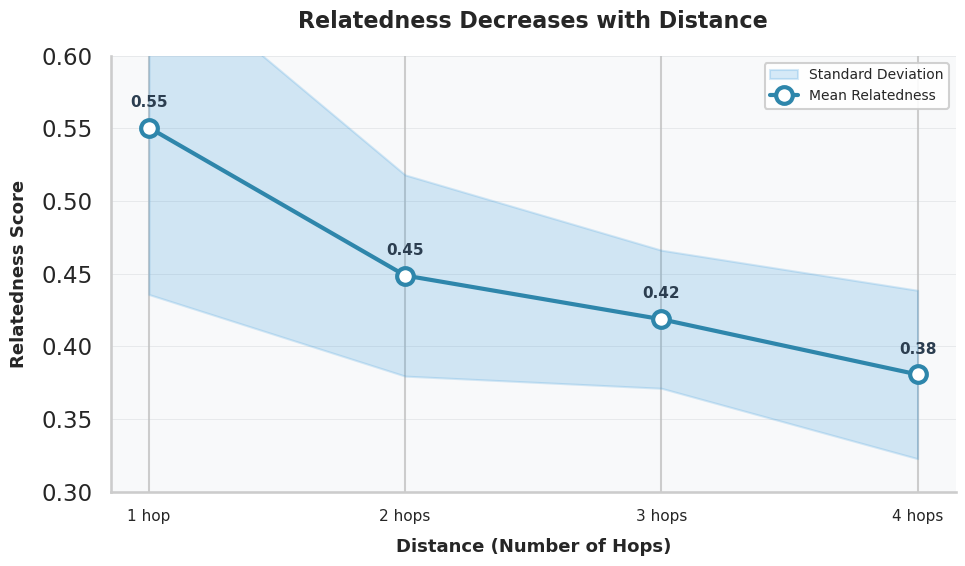

In [ ]:
# Plot relatedness vs hop distance with standard deviation band
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('#F8F9FA')

ax.fill_between(
    hops,
    means - stds,
    means + stds,
    color='#3498DB',
    alpha=0.2,
    label='Standard Deviation'
)

ax.plot(
    hops,
    means,
    color='#2E86AB',
    linewidth=3,
    marker='o',
    markersize=12,
    markerfacecolor='white',
    markeredgewidth=3,
    markeredgecolor='#2E86AB',
    zorder=5,
    label='Mean Relatedness'
)

for h, m in zip(hops, means):
    ax.annotate(
        f'{m:.2f}',
        xy=(h, m),
        xytext=(0, 15),
        textcoords='offset points',
        ha='center',
        fontsize=11,
        fontweight='bold',
        color='#2C3E50'
    )

ax.set_xlabel('Distance (Number of Hops)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel('Relatedness Score', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('Relatedness Decreases with Distance', fontsize=16, fontweight='bold', pad=20)

ax.set_xticks(hops)
ax.set_xticklabels([f'{int(h)} hop{"s" if h>1 else ""}' for h in hops], fontsize=11)
ax.set_ylim(0.3, 0.6)

ax.grid(axis='y', alpha=0.4, linestyle='-', linewidth=0.5, color='#BDC3C7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()


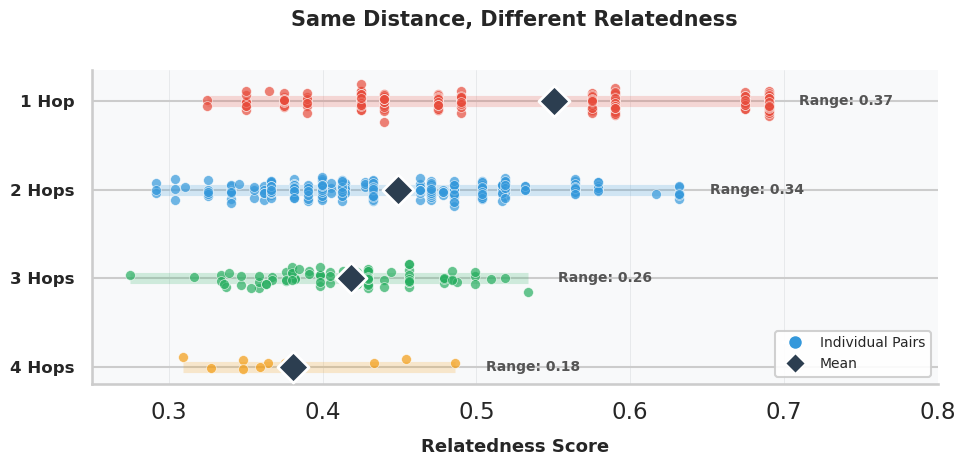

KEY INSIGHT: Relation Type Matters, Not Just Distance
  At 1 hop: scores range from 0.32 to 0.69
  Parent->Child has higher score than Cousin->Cousin
  even though both are 1 hop apart!


In [ ]:
# Relatedness Variance - Same Distance, Different Scores 
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('#F8F9FA')

hop_range = df_all_comp.groupby('hops')['relatedness'].agg(['min', 'max', 'mean']).reset_index()

colors = ['#E74C3C', '#3498DB', '#27AE60', '#F39C12', '#9B59B6']
y_positions = np.arange(len(hop_range))

np.random.seed(42)

for i, row in hop_range.iterrows():
    hop_val = row['hops']
    
    ax.hlines(y=i, xmin=row['min'], xmax=row['max'], 
              color=colors[i % len(colors)], linewidth=8, alpha=0.2)
    
    hop_data = df_all_comp[df_all_comp['hops'] == hop_val]['relatedness']
    jitter = np.random.normal(0, 0.06, len(hop_data))
    ax.scatter(hop_data, i + jitter, s=50, color=colors[i % len(colors)], 
               edgecolor='white', linewidth=0.5, alpha=0.7, zorder=4)
    
    ax.scatter(row['mean'], i, s=250, color='#2C3E50', 
               edgecolor='white', linewidth=2, zorder=6, marker='D')
    
    range_val = row['max'] - row['min']
    ax.annotate(f'Range: {range_val:.2f}', xy=(row['max'] + 0.02, i), 
                fontsize=10, va='center', color='#555555', fontweight='bold')

ax.set_yticks(y_positions)
ax.set_yticklabels([f"{int(h)} Hop{'s' if h>1 else ''}" for h in hop_range['hops']], 
                   fontsize=12, fontweight='bold')
ax.set_xlabel('Relatedness Score', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('Same Distance, Different Relatedness\n', 
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlim(0.25, 0.8)
ax.grid(axis='x', alpha=0.4, linestyle='-', linewidth=0.5, color='#BDC3C7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498DB', 
           markersize=10, label='Individual Pairs'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='#2C3E50', 
           markersize=10, label='Mean')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()

print("KEY INSIGHT: Relation Type Matters, Not Just Distance")
print(f"  At 1 hop: scores range from {hop_range.iloc[0]['min']:.2f} to {hop_range.iloc[0]['max']:.2f}")
print(f"  Parent->Child has higher score than Cousin->Cousin")
print(f"  even though both are 1 hop apart!")


## Conclusions

### 1. Community Detection Quality
- **Louvain** optimizes modularity directly and works well on family graphs
- **Spectral Clustering** uses graph Laplacian - we control k and pick best modularity

### 2. Communities vs Family Units
- Detected communities show moderate-to-high nuclear family density
- Smaller communities tend to be more nuclear-family aligned
- Extended family branches form their own distinct communities

### 3. Generational Structure
- Most communities span 3-4 generations
- This suggests communities often capture parent-children-grandchildren lineages

### 4. Bridge Individuals
- Bridge nodes typically occupy parent/grandparent positions
- They connect different branches (e.g., maternal vs paternal sides)
- Often have high degree and betweenness centrality

### 5. Relatedness Metric
- Simple hop count ignores relationship semantics
- Our weighted metric captures:
  - Closeness (path length)
  - Relationship strength (parent > cousin)
  - Community membership
- Two people at distance 1 can have different relatedness if path is parent→child vs cousin→cousin